In [1]:
! pip install datasets
! pip install transformers
! pip install scikit-learn
! pip install pandas
! pip install accelerate
! pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 3.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_6

# FinBert

In [4]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

def compute_accuracy(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {"accuracy": accuracy_score(labels, preds)}

# Load the CSV dataset
df = pd.read_csv('feb_march_Headlines_English_Apple_Market_Time_Sentiment_6.csv')
df['Sentiment'] = df['Sentiment'].replace(['positive', 'negative', 'neutral'], [0, 1, 2])

# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Cleaned_Headline'], df['Sentiment'],
                                                                      test_size=0.2, random_state=42)
train_indices, test_indices = train_test_split(df.index, test_size=0.2, random_state=42)

# Define the tokenizer and encode the data

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
print("Model and Tokenizer Loaded")
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)
print("Tokenization done")

# Convert labels to tensors
train_labels = torch.tensor(train_labels.tolist())
test_labels = torch.tensor(test_labels.tolist())

# Create a dataset
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'],
                                   'attention_mask': train_encodings['attention_mask'],
                                   'labels': train_labels})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'],
                                  'attention_mask': test_encodings['attention_mask'],
                                  'labels': test_labels})

# Fine-tune the model
training_args = TrainingArguments(
    num_train_epochs=3,
    output_dir = './output',
    evaluation_strategy = 'epoch',
    do_train = True,
    logging_steps = 10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_accuracy
)

trainer.train()

predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)
max_prediction_scores = torch.softmax(torch.tensor(predictions.predictions), dim = 1).max(-1)
max_prediction_scores_original = predictions.predictions.max(-1)

Model and Tokenizer Loaded
Tokenization done


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.185762,0.538462
2,1.067600,0.715899,0.692308
3,1.067600,0.643481,0.692308


In [ ]:
df_headline_dates = pd.read_csv("feb_march_Headlines_English_Apple_Market_Time_Final_6.csv")
df_stock_prices = pd.read_csv("feb_march_Apple_stocks_6.csv")

In [ ]:
df_headline_dates['Datetime'] = pd.to_datetime(df_headline_dates['Date']).dt.strftime('%d/%m/%Y') + ' ' + pd.to_datetime(df_headline_dates['Time']).dt.strftime('%H:%M:%S')
df_headline_dates

<ipython-input-75-c543393f820b>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_headline_dates['Datetime'] = pd.to_datetime(df_headline_dates['Date']).dt.strftime('%d/%m/%Y') + ' ' + pd.to_datetime(df_headline_dates['Time']).dt.strftime('%H:%M:%S')
<ipython-input-75-c543393f820b>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_headline_dates['Datetime'] = pd.to_datetime(df_headline_dates['Date']).dt.strftime('%d/%m/%Y') + ' ' + pd.to_datetime(df_headline_dates['Time']).dt.strftime('%H:%M:%S')


,Unnamed: 0,Date,Time,Cleaned_Headline,Datetime
0,0,19/02/2024,9:31:00,There Are 2.2 Billion Reasons to Buy Apple Sto...,19/02/2024 09:31:00
1,1,19/02/2024,9:31:00,EU regulators reportedly will fine Apple more ...,19/02/2024 09:31:00
2,2,21/02/2024,11:36:00,"Apple, Kai Fa Zhe Xiang keni[macOS 14.4 Sonoma...",21/02/2024 11:36:00
3,3,21/02/2024,12:07:00,Apple's newest app is a thrilling gift for spo...,21/02/2024 12:07:00
4,4,22/02/2024,9:31:00,"Apple, Zui Xin nomacOS 14 SonomayaiOS 17, Visi...",22/02/2024 09:31:00
...,...,...,...,...,...
56,72,11/04/2024,9:31:00,Apple M1/M3chitsupuDa Zai noiMacyaStudio Displ...,11/04/2024 09:31:00
57,73,11/04/2024,10:57:23,"Judge in Apple antitrust case steps down, due ...",11/04/2024 10:57:23
58,74,12/04/2024,9:31:00,Apple's Services business is a bright spot in ...,12/04/2024 09:31:00
59,75,12/04/2024,13:06:54,Apple's earnings power is once again being ove...,12/04/2024 13:06:54


In [ ]:
test_labels

tensor([2, 0, 1, 1, 1, 1, 0, 0, 2, 1, 1, 0, 2])

### Sorting the Test Prediction in increasing Order of Date

In [ ]:
test_df = pd.DataFrame()
test_df['Test Dates'] = pd.to_datetime(df_headline_dates['Datetime'][test_indices]).dt.strftime('%d/%m/%Y')
test_df['Test Dates'] = df_headline_dates['Datetime'][test_indices]
test_df['True Labels'] = test_labels
test_df['Predicted Labels'] = max_prediction_scores.indices
test_df['Date'] = pd.to_datetime(test_df['Test Dates']).dt.strftime('%d/%m/%Y')
test_df['Time'] = pd.to_datetime(test_df['Test Dates']).dt.time
test_df

<ipython-input-77-d05088613cca>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  test_df['Test Dates'] = pd.to_datetime(df_headline_dates['Datetime'][test_indices]).dt.strftime('%d/%m/%Y')
<ipython-input-77-d05088613cca>:8: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  test_df['Date'] = pd.to_datetime(test_df['Test Dates']).dt.strftime('%d/%m/%Y')
<ipython-input-77-d05088613cca>:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  test_df['Time'] = pd.to_datetime(test_df['Test Dates']).dt.time


,Test Dates,Scores,True Labels,Predicted Labels,Date,Time
0,19/02/2024 09:31:00,0.489619,2,0,19/02/2024,09:31:00
5,26/02/2024 09:31:00,0.939438,0,0,26/02/2024,09:31:00
46,04/04/2024 09:31:00,0.955831,1,1,04/04/2024,09:31:00
31,18/03/2024 09:31:00,0.810590,1,1,18/03/2024,09:31:00
13,29/02/2024 09:31:00,0.881176,1,1,29/02/2024,09:31:00
55,10/04/2024 10:56:06,0.821936,1,1,10/04/2024,10:56:06
34,23/03/2024 12:00:00,0.786765,0,1,23/03/2024,12:00:00
49,05/04/2024 09:31:00,0.516179,0,0,05/04/2024,09:31:00
12,29/02/2024 15:00:00,0.573614,2,2,29/02/2024,15:00:00
40,01/04/2024 14:50:31,0.806314,1,1,01/04/2024,14:50:31


In [ ]:
test_df_sorted['Date'] = pd.to_datetime(test_df['Date'], format='%d/%m/%Y', dayfirst = True)  # Convert to datetime format if not already
test_df['Date'] = pd.to_datetime(test_df['Date'], format='%d/%m/%Y', dayfirst = True)  # Convert to datetime format if not already

test_df_sorted = test_df.sort_values(by=['Date'], ascending=True)
test_df_sorted

,Test Dates,Scores,True Labels,Predicted Labels,Date,Time
0,19/02/2024 09:31:00,0.489619,2,0,2024-02-19,09:31:00
5,26/02/2024 09:31:00,0.939438,0,0,2024-02-26,09:31:00
13,29/02/2024 09:31:00,0.881176,1,1,2024-02-29,09:31:00
12,29/02/2024 15:00:00,0.573614,2,2,2024-02-29,15:00:00
16,05/03/2024 09:31:00,0.528746,2,0,2024-03-05,09:31:00
31,18/03/2024 09:31:00,0.810590,1,1,2024-03-18,09:31:00
33,22/03/2024 11:00:00,0.789235,1,1,2024-03-22,11:00:00
34,23/03/2024 12:00:00,0.786765,0,1,2024-03-23,12:00:00
40,01/04/2024 14:50:31,0.806314,1,1,2024-04-01,14:50:31
46,04/04/2024 09:31:00,0.955831,1,1,2024-04-04,09:31:00


### True Vs Predicted Labels

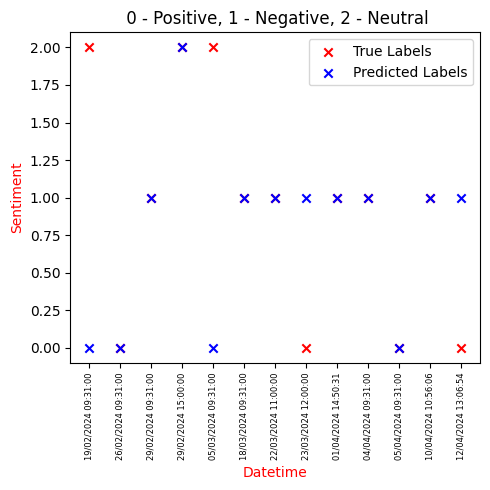

In [ ]:
# Plot sentiment classification
import matplotlib.pyplot as plt

fig  = plt.figure(figsize = (5,5))
plt.scatter(test_df_sorted['Test Dates'],test_df_sorted['True Labels'],  marker='x', color = 'r', label = 'True Labels')
plt.scatter(test_df_sorted['Test Dates'],test_df_sorted['Predicted Labels'],  marker='x', color = 'b', label = 'Predicted Labels')
plt.xlabel('Datetime', color='r')
plt.ylabel('Sentiment', color='r')
plt.xticks(rotation=90, fontsize=6)  # Rotate the x-axis labels by 90 degrees
plt.title(" 0 - Positive, 1 - Negative, 2 - Neutral")
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

### Predicted Labels

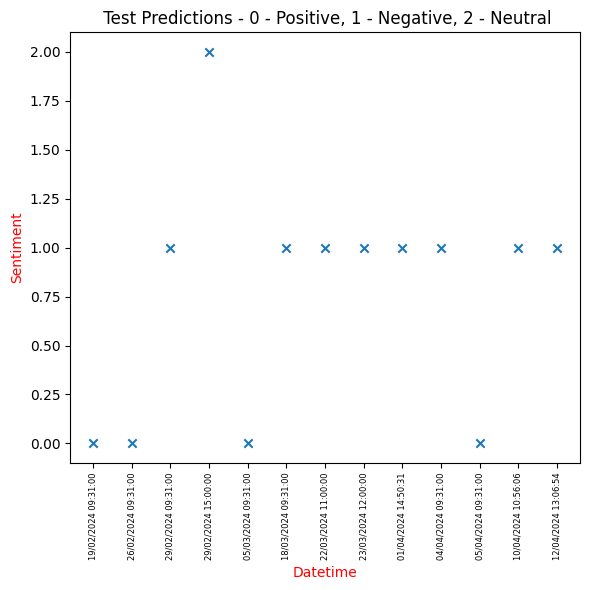

In [ ]:
# Plot sentiment classification on the secondary y-axis
fig  = plt.figure(figsize = (6,6))
plt.scatter(test_df_sorted['Test Dates'],test_df_sorted['Predicted Labels'],  marker='x')
plt.xlabel('Datetime', color='r')
plt.ylabel('Sentiment', color='r')
plt.xticks(rotation=90, fontsize=6)  # Rotate the x-axis labels by 90 degrees
plt.title(" Test Predictions - 0 - Positive, 1 - Negative, 2 - Neutral")
plt.tight_layout()
plt.show()

### Plot of Stock Prices of the dates in Test Set

In [ ]:
filtered_stock_df = df_stock_prices.loc[df_stock_prices['Date'].isin(df_headline_dates['Date'][test_indices].values)]
# filtered_stock_df.head(5)

In [ ]:
def remove_last_6_chars(s):
    return s[:-6]

filtered_stock_df['Datetime'] = filtered_stock_df['Datetime'].apply(lambda x: remove_last_6_chars(x))

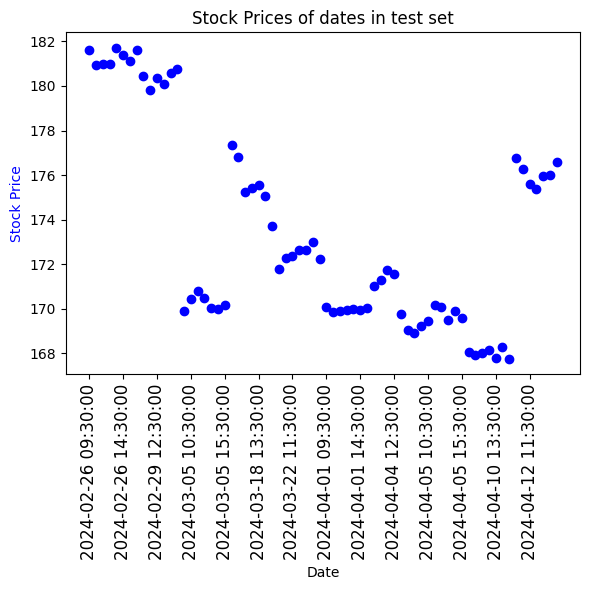

In [ ]:
fig  = plt.figure(figsize = (6,6))
plt.scatter(filtered_stock_df['Datetime'], filtered_stock_df['Adj Close'], color='b')
plt.xlabel('Date')
plt.xticks(filtered_stock_df['Datetime'][::5], rotation=90, fontsize=12)  # Display every 5th value on x axis
plt.ylabel('Stock Price', color='b')
plt.title("Stock Prices of dates in test set")
plt.tight_layout()
plt.show()

### Plot of Prices from 16th Feb to 14th April

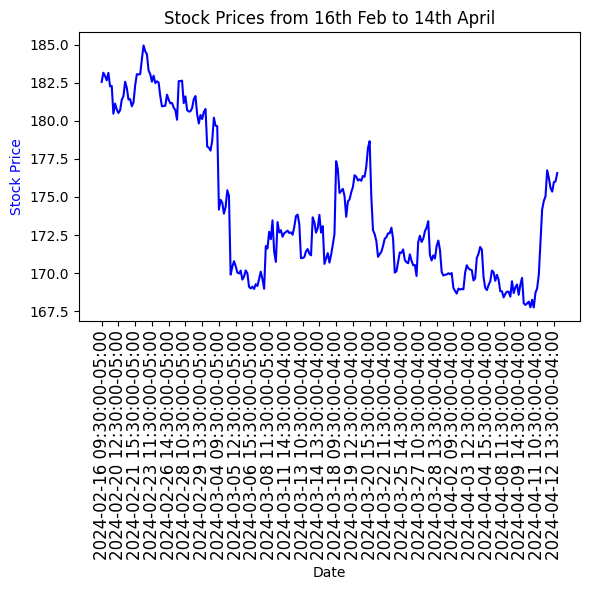

In [ ]:
# Plot stock price on the primary y-axis
fig  = plt.figure(figsize = (6,6))
plt.plot(df_stock_prices['Datetime'], df_stock_prices['Adj Close'], color='b')
plt.xlabel('Date')
# plt.xticks(rotation=90, fontsize=2)  # Rotate the x-axis labels by 90 degrees
# Set x-axis ticks with a specific frequency
plt.xticks(df_stock_prices['Datetime'][::10], rotation=90, fontsize=12)  # Display every 10th date
plt.ylabel('Stock Price', color='b')
plt.title("Stock Prices from 16th Feb to 14th April")
plt.tight_layout()
plt.show()

In [ ]:
trainer.evaluate()

{'eval_loss': 0.7146786451339722,
 'eval_accuracy': 0.6923076923076923,
 'eval_runtime': 0.0562,
 'eval_samples_per_second': 231.424,
 'eval_steps_per_second': 35.604,
 'epoch': 3.0}

# GAT Model

In [ ]:
! pip install dgl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import itertools

# Load dataset
data = pd.read_csv("feb_march_Headlines_English_Apple_Market_Time_Sentiment_6.csv")

# Preprocessing
X = data['Cleaned_Headline'].values
y = data['Sentiment'].values

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_indices, test_indices = train_test_split(data.index, test_size=0.2, random_state=42)


# Feature extraction (CountVectorizer)
count_vectorizer = CountVectorizer(max_features=1000)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# Encode labels
y_train_encoded = np.where(y_train == 'positive', 0, np.where(y_train == 'negative', 1, 2))
y_test_encoded = np.where(y_test == 'positive', 0, np.where(y_test == 'negative', 1, 2))

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_count.toarray(), dtype=torch.float)
X_test_tensor = torch.tensor(X_test_count.toarray(), dtype=torch.float)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Compute edge indices based on cosine similarity
train_similarities = cosine_similarity(X_train_count)
test_similarities = cosine_similarity(X_test_count)

train_edge_indices = []
# print("Train ")
for i, j in itertools.combinations(range(len(X_train_tensor)), 2):
  # print("test_similarities[i, j] ", X_train_tensor[i, j])
  if train_similarities[i, j] >= 0.4:  # Adjust threshold as needed
      train_edge_indices.append([i, j])

test_edge_indices = []
# print("Test ")
for i, j in itertools.combinations(range(len(X_test_tensor)), 2):
  # print("test_similarities[i, j] ", test_similarities[i, j])
  if test_similarities[i, j] >= 0.4:  # Adjust threshold as needed
    test_edge_indices.append([i, j])

# Convert edge indices to tensors
train_edge_index = torch.tensor(train_edge_indices, dtype=torch.long).t().contiguous()
test_edge_index = torch.tensor(test_edge_indices, dtype=torch.long).t().contiguous()

# Define GCN-based sentiment classifier
class GATSentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, heads=1):
        super(GATSentimentClassifier, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.conv2 = GATConv(hidden_dim * heads, num_classes, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = nn.Dropout(p=0.5)(x)
        x = self.conv2(x, edge_index)
        return x

# Construct data objects for training and testing
train_data = Data(x=X_train_tensor, edge_index=train_edge_index, y=y_train_tensor)
test_data = Data(x=X_test_tensor, edge_index=test_edge_index, y=y_test_tensor)

# Create DataLoader
train_loader = DataLoader([train_data], batch_size=10, shuffle=True)
test_loader = DataLoader([test_data], batch_size=10)

# Initialize model
input_dim = X_train_tensor.shape[1]
hidden_dim = 20
num_classes = 3
num_heads = 2  # Number of attention heads
model = GATSentimentClassifier(input_dim, hidden_dim, num_classes, heads=num_heads)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training
model.train()
for epoch in range(20):  # You can adjust the number of epochs
    epoch_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Calculate test loss and accuracy after each epoch
    model.eval()
    y_pred = []
    # y_true = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_pred.extend(pred.tolist())
        # y_true.extend(data.y.tolist())

    test_accuracy = accuracy_score(y_true, y_pred)
    epoch_loss /= len(train_loader)

    print(f"Epoch {epoch+1}/{50}, Train Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

print("Training finished.")

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Train Loss: 1.0897, Test Accuracy: 0.2308
Epoch 2/50, Train Loss: 1.0919, Test Accuracy: 0.0769
Epoch 3/50, Train Loss: 0.9099, Test Accuracy: 0.3077
Epoch 4/50, Train Loss: 0.8744, Test Accuracy: 0.4615
Epoch 5/50, Train Loss: 0.7402, Test Accuracy: 0.6154
Epoch 6/50, Train Loss: 0.7753, Test Accuracy: 0.3846
Epoch 7/50, Train Loss: 0.6898, Test Accuracy: 0.3077
Epoch 8/50, Train Loss: 0.6128, Test Accuracy: 0.6154
Epoch 9/50, Train Loss: 0.5756, Test Accuracy: 0.3077
Epoch 10/50, Train Loss: 0.5779, Test Accuracy: 0.6154
Epoch 11/50, Train Loss: 0.4683, Test Accuracy: 0.6154
Epoch 12/50, Train Loss: 0.4285, Test Accuracy: 0.5385
Epoch 13/50, Train Loss: 0.3936, Test Accuracy: 0.5385
Epoch 14/50, Train Loss: 0.3597, Test Accuracy: 0.3846
Epoch 15/50, Train Loss: 0.3201, Test Accuracy: 0.5385
Epoch 16/50, Train Loss: 0.3518, Test Accuracy: 0.4615
Epoch 17/50, Train Loss: 0.2359, Test Accuracy: 0.3846
Epoch 18/50, Train Loss: 0.2856, Test Accuracy: 0.4615
Epoch 19/50, Train 

In [ ]:
df_headline_dates = pd.read_csv("feb_march_Headlines_English_Apple_Market_Time_Final_6.csv")
df_stock_prices = pd.read_csv("feb_march_Apple_stocks_6.csv")

In [ ]:
df_headline_dates['Datetime'] = pd.to_datetime(df_headline_dates['Date']).dt.strftime('%d/%m/%Y') + ' ' + pd.to_datetime(df_headline_dates['Time']).dt.strftime('%H:%M:%S')

<ipython-input-53-dc0a24c5a2ea>:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_headline_dates['Datetime'] = pd.to_datetime(df_headline_dates['Date']).dt.strftime('%d/%m/%Y') + ' ' + pd.to_datetime(df_headline_dates['Time']).dt.strftime('%H:%M:%S')
<ipython-input-53-dc0a24c5a2ea>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_headline_dates['Datetime'] = pd.to_datetime(df_headline_dates['Date']).dt.strftime('%d/%m/%Y') + ' ' + pd.to_datetime(df_headline_dates['Time']).dt.strftime('%H:%M:%S')


### Sorting the Test Prediction in increasing Order of Date

In [ ]:
test_df = pd.DataFrame()
# test_df['Test Dates'] = pd.to_datetime(df_headline_dates['Datetime'][test_indices]).dt.strftime('%d/%m/%Y')
test_df['Test Dates'] = df_headline_dates['Datetime'][test_indices]
test_df['True Labels'] = y_test_encoded
test_df['Predicted Labels'] = y_pred
test_df['Date'] = pd.to_datetime(test_df['Test Dates']).dt.strftime('%d/%m/%Y')
test_df['Time'] = pd.to_datetime(test_df['Test Dates']).dt.time
test_df

<ipython-input-55-84e76aebede2>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  test_df['Test Dates'] = pd.to_datetime(df_headline_dates['Datetime'][test_indices]).dt.strftime('%d/%m/%Y')
<ipython-input-55-84e76aebede2>:8: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  test_df['Date'] = pd.to_datetime(test_df['Test Dates']).dt.strftime('%d/%m/%Y')
<ipython-input-55-84e76aebede2>:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  test_df['Time'] = pd.to_datetime(test_df['Test Dates']).dt.time


,Test Dates,True Labels,Predicted Labels,Date,Time
0,19/02/2024 09:31:00,2,2,19/02/2024,09:31:00
5,26/02/2024 09:31:00,0,1,26/02/2024,09:31:00
46,04/04/2024 09:31:00,1,1,04/04/2024,09:31:00
31,18/03/2024 09:31:00,1,1,18/03/2024,09:31:00
13,29/02/2024 09:31:00,1,2,29/02/2024,09:31:00
55,10/04/2024 10:56:06,1,2,10/04/2024,10:56:06
34,23/03/2024 12:00:00,0,1,23/03/2024,12:00:00
49,05/04/2024 09:31:00,0,1,05/04/2024,09:31:00
12,29/02/2024 15:00:00,2,2,29/02/2024,15:00:00
40,01/04/2024 14:50:31,1,1,01/04/2024,14:50:31


In [ ]:
test_df_sorted = pd.DataFrame()
test_df_sorted['Date'] = pd.to_datetime(test_df['Date'], format='%d/%m/%Y', dayfirst = True)  # Convert to datetime format if not already
test_df['Date'] = pd.to_datetime(test_df['Date'], format='%d/%m/%Y', dayfirst = True)  # Convert to datetime format if not already

test_df_sorted = test_df.sort_values(by=['Date'], ascending=True)
test_df_sorted

,Test Dates,True Labels,Predicted Labels,Date,Time
0,19/02/2024 09:31:00,2,2,2024-02-19,09:31:00
5,26/02/2024 09:31:00,0,1,2024-02-26,09:31:00
13,29/02/2024 09:31:00,1,2,2024-02-29,09:31:00
12,29/02/2024 15:00:00,2,2,2024-02-29,15:00:00
16,05/03/2024 09:31:00,2,2,2024-03-05,09:31:00
31,18/03/2024 09:31:00,1,1,2024-03-18,09:31:00
33,22/03/2024 11:00:00,1,1,2024-03-22,11:00:00
34,23/03/2024 12:00:00,0,1,2024-03-23,12:00:00
40,01/04/2024 14:50:31,1,1,2024-04-01,14:50:31
46,04/04/2024 09:31:00,1,1,2024-04-04,09:31:00


In [ ]:
filtered_stock_df = df_stock_prices.loc[df_stock_prices['Date'].isin(df_headline_dates['Date'][test_indices].values)]
filtered_stock_df.head(5)

,Unnamed: 0,Datetime,Date,Time,Adj Close
35,35,2024-02-26 09:30:00-05:00,26/02/2024,9:30:00,181.602203
36,36,2024-02-26 10:30:00-05:00,26/02/2024,10:30:00,180.940002
37,37,2024-02-26 11:30:00-05:00,26/02/2024,11:30:00,180.970001
38,38,2024-02-26 12:30:00-05:00,26/02/2024,12:30:00,180.985001
39,39,2024-02-26 13:30:00-05:00,26/02/2024,13:30:00,181.712006


### Predicted Labels

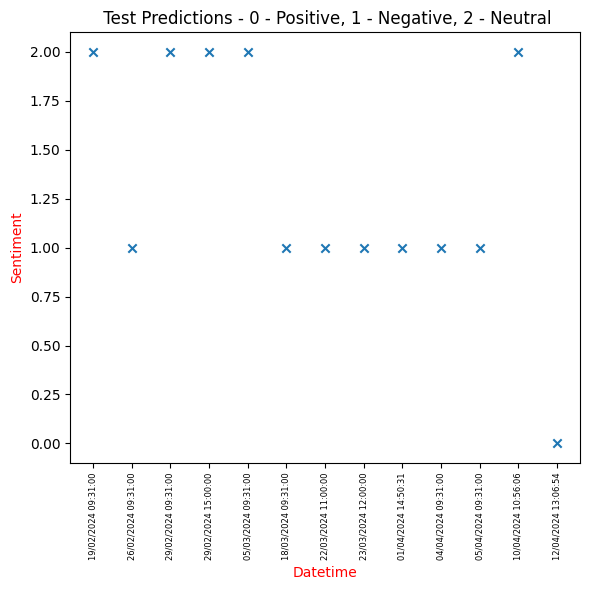

In [ ]:
import matplotlib.pyplot as plt

fig  = plt.figure(figsize = (6,6))
plt.scatter(test_df_sorted['Test Dates'],test_df_sorted['Predicted Labels'],  marker='x')
plt.xlabel('Datetime', color='r')
plt.ylabel('Sentiment', color='r')
plt.xticks(rotation=90, fontsize=6)  # Rotate the x-axis labels by 90 degrees
plt.title(" Test Predictions - 0 - Positive, 1 - Negative, 2 - Neutral")
plt.tight_layout()
plt.show()

### True Vs Predicted Labels

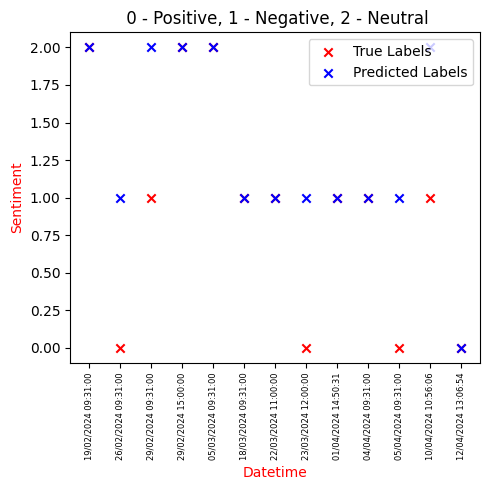

In [ ]:
import matplotlib.pyplot as plt

fig  = plt.figure(figsize = (5,5))
plt.scatter(test_df_sorted['Test Dates'],test_df_sorted['True Labels'],  marker='x', color = 'r', label = 'True Labels')
plt.scatter(test_df_sorted['Test Dates'],test_df_sorted['Predicted Labels'],  marker='x', color = 'b', label = 'Predicted Labels')
plt.xlabel('Datetime', color='r')
plt.ylabel('Sentiment', color='r')
plt.xticks(rotation=90, fontsize=6)  # Rotate the x-axis labels by 90 degrees
plt.title(" 0 - Positive, 1 - Negative, 2 - Neutral")
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

### Plot of Stock Prices of the dates in Test Set

In [ ]:
def remove_last_6_chars(s):
    return s[:-6]

# Apply the function to the column
filtered_stock_df['Datetime'] = filtered_stock_df['Datetime'].apply(lambda x: remove_last_6_chars(x))

<ipython-input-63-e1c5bbb14d62>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_stock_df['Datetime'] = filtered_stock_df['Datetime'].apply(lambda x: remove_last_6_chars(x))


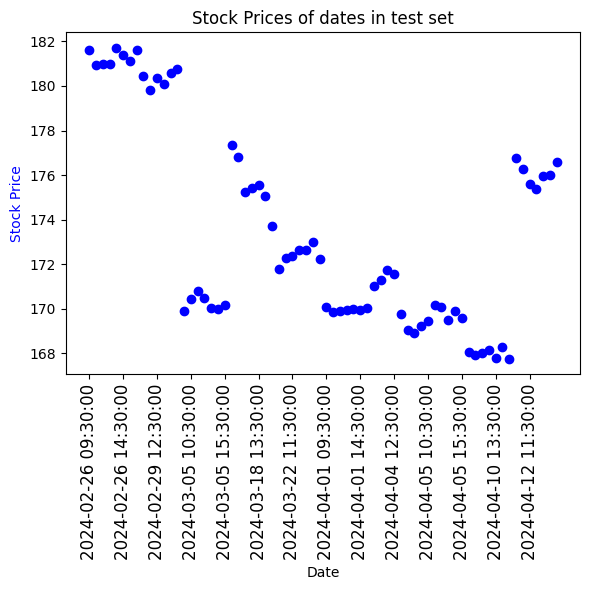

In [ ]:
fig  = plt.figure(figsize = (6,6))
plt.scatter(filtered_stock_df['Datetime'], filtered_stock_df['Adj Close'], color='b')
plt.xlabel('Date')
# plt.xticks(rotation=90, fontsize=6)  # Rotate the x-axis labels by 90 degrees
plt.xticks(filtered_stock_df['Datetime'][::5], rotation=90, fontsize=12)  # Display every 10th date
plt.ylabel('Stock Price', color='b')
plt.title("Stock Prices of dates in test set")
plt.tight_layout()
plt.show()